In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance_metrics import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance_metrics as perf
import trend_following as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)

<module 'trend_following' from '/Users/adheerchauhan/Documents/git/trend_following/trend_following.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper functions to help pull the data and run the analysis

### Moving Average and Donchian Channels Signals

In [10]:
from strategy_performance_metrics import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance(df_performance, ticker):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'{ticker} Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'{ticker} Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'{ticker} Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    # Generate Trend Signal
    if use_coinbase_data:
        df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = tf.get_close_prices(start_date, end_date, ticker, print_status=False)
    df_trend = (tf.create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))
    # Generate Donchian Signal
    df_donchian = tf.calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                            rolling_donchian_window=rolling_donchian_window, use_coinbase_data=use_coinbase_data)
    if price_or_returns_calc == 'price':

        # Buy signal: Price crosses above upper band
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'close'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
            np.where((df_donchian[f'close'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']), -1, 0))
    elif price_or_returns_calc == 'returns':
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'{ticker}_pct_returns'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_returns']), 1,
            np.where((df_donchian[f'{ticker}_pct_returns'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_returns']), -1, 0))

    # Merging the Trend and donchian Dataframes
    donchian_cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}',
                     f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_signal']
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    if include_signal_strength:
        # Calculate the strength of moving average crossover and donchian signal
        df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'] = (df_trend[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] -
                                                                             df_trend[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'])
        donchian_strength = (np.abs(df_trend[f'{ticker}'] - df_trend[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}']) /
                             df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'])
        crossover_strength = np.abs(df_trend[f'{ticker}_{fast_mavg}_mavg'] - df_trend[f'{ticker}_{slow_mavg}_mavg']) / df_trend[f'{ticker}']

        df_trend[f'{ticker}_crossover_donchian_signal_strength'] = (donchian_strength + crossover_strength) / 2
        strength_threshold = 0.5
    
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1) &
                      (df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1) &
                       ((df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold)))
    else:
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1))
    
    if long_only:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, 0))
    else:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, np.where(sell_signal, -1, 0)))
        
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')] * 
        df_trend[f'{ticker}_pct_returns'])
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')].diff())
    
    return df_trend

def moving_avg_crossover_with_donchian_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                           rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    perf_cols = ['ticker', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    fast_mavg_list = np.arange(10, 101, 10)
    slow_mavg_list = np.arange(50, 501, 50)
    mavg_stepsize_list = [2, 4, 6, 8]
    performance_rows = []
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for mavg_stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df_trend = generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type, price_or_returns_calc,
                                                                         rolling_donchian_window, include_signal_strength, long_only, use_coinbase_data)
                    performance_metrics = calculate_risk_and_performance_metrics(
                        df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                        strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                        annual_trading_days=365, transaction_cost_est=0.005)
                    performance_rows.append({
                        'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': mavg_stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    })
                    # df_performance = df_performance.append(row, ignore_index=True)
    # Convert the list of rows to a DataFrame
    df_performance = pd.DataFrame(performance_rows, columns=perf_cols)
    
    plot_moving_avg_crossover_performance(df_performance, ticker)
    
    return df_performance

In [12]:
def calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc='price', rolling_atr_window=20,
                                 use_coinbase_data=True):
    if use_coinbase_data:
        df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose', f'{ticker}_volume']

    if price_or_returns_calc == 'price':
        # Calculate the Exponential Moving Average (EMA)
        # df[f'{ticker}_{rolling_atr_window}_ema_price'] = df['close'].ewm(span=rolling_atr_window,
        #                                                                  adjust=False).mean()

        # Calculate the True Range (TR) and Average True Range (ATR)
        df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
        df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_true_range_price'] = df[
            [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        # Calculate Middle Line as the EMA of returns
        df[f'{ticker}_{rolling_atr_window}_ema_returns'] = df[f'{ticker}_pct_returns'].ewm(span=rolling_atr_window,
                                                                                           adjust=False).mean()

        # Calculate True Range based on absolute returns
        df[f'{ticker}_true_range_returns'] = df[f'{ticker}_{rolling_atr_window}_ema_returns'].abs()

        # Calculate ATR using the EMA of the True Range
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'] = df[f'{ticker}_true_range_returns'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    return df

In [14]:
## In Sample Performance
# in_sample_start_date = pd.Timestamp(2014, 9, 17).date()
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2022, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2023, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2024, 9, 30).date()
full_sample_start_date = pd.Timestamp(2014, 9, 17).date()
full_sample_end_date = pd.Timestamp(2024, 9, 30).date()

In [16]:
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=20,
                                     use_coinbase_data=True)

In [24]:
ticker = 'BTC-USD'
rolling_atr_window = 20
df_atr[[f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1).head()

BTC-USD_20_avg_true_range_price
date                                       
2016-01-01                              NaN
2016-01-02                         9.230000
2016-01-03                         8.841429
2016-01-04                         9.021293
2016-01-05                         8.583074

In [26]:
df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, 
                                                       mavg_stepsize=6, rolling_donchian_window=20, price_or_returns_calc='price', long_only=False, include_signal_strength=False)

In [28]:
trend_cols = ['BTC-USD','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']
df_returns = df_trend[trend_cols]
# df_returns = pd.merge(df_returns, df_atr, left_index=True, right_index=True, how='left')

In [401]:
def get_volatility_scaled_target_position_size(start_date, end_date, ticker, rolling_atr_window, position_size_atr_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, high_volatility_threshold=1.5,
                                               use_coinbase_data=True, price_or_returns_calc='price'):
    ## Calculate the Average True Range
    df = calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc, rolling_atr_window, use_coinbase_data)
    df = df[[f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1)

    ## Determine if the Volatility Regime is High or Low
    df[f'{ticker}_volatility_regime'] = np.where((df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] > high_volatility_threshold *
                                                  df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].rolling(window=50).mean()), 'High', 'Low')
    df[f'{ticker}_volatility_regime'] = df[f'{ticker}_volatility_regime'].shift(1)

    ## Calculate Volatility Scaled Target Position
    df[f'{ticker}_target_position_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
    df[f'{ticker}_target_position_notional'] = np.where(df[f'{ticker}_volatility_regime'] == 'High', df[f'{ticker}_target_position_notional'] * 0.5, df[f'{ticker}_target_position_notional'])
    df[f'{ticker}_target_position_notional'] = df[f'{ticker}_target_position_notional'].fillna(0)

    ## Cap position size to not exceed initial capital
    df[f'{ticker}_target_position_notional'] = df[f'{ticker}_target_position_notional'].clip(upper=initial_capital)

    ## Shift position sizes by 1 to avoid lookahead bias
    df[f'{ticker}_target_position_notional'] = df[f'{ticker}_target_position_notional'].shift(1)
    
    return df

In [431]:
df_price = cn.get_coinbase_ohlc_data(ticker=ticker)

In [459]:
df_position.head()

DOGE-USD_20_avg_true_range_price DOGE-USD_volatility_regime  \
date                                                                      
2021-06-03                               NaN                       None   
2021-06-04                          0.109600                        Low   
2021-06-05                          0.104295                        Low   
2021-06-06                          0.097696                        Low   
2021-06-07                          0.089391                        Low   

            DOGE-USD_target_position_notional     low    high    open   close  \
date                                                                            
2021-06-03                                NaN  0.3779  0.4875  0.4875  0.4015   
2021-06-04                                0.0  0.3500  0.4039  0.4015  0.3769   
2021-06-05                            15000.0  0.3598  0.3948  0.3769  0.3718   
2021-06-06                            15000.0  0.3669  0.3774  0.3718  0.3717   
2021-06-07                            15000.0  0.3274  0.3800  0.3719  0.3315   

                 volume  
date                     
2021-06-03  190111721.7  
2021-06-04  570165109.2  
2021-06-05  221827648.1  
2021-06-06  125063397.2  
2021-06-07  205450202.3

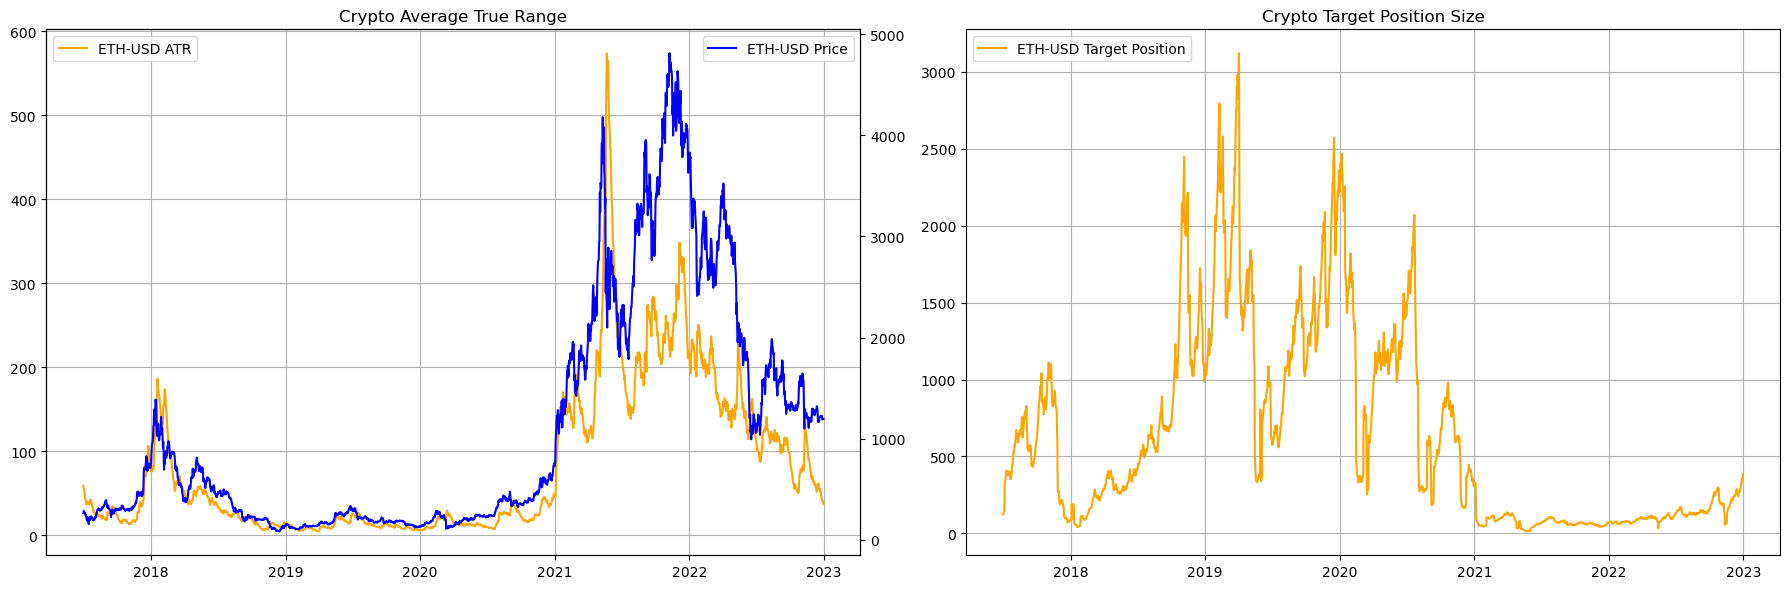

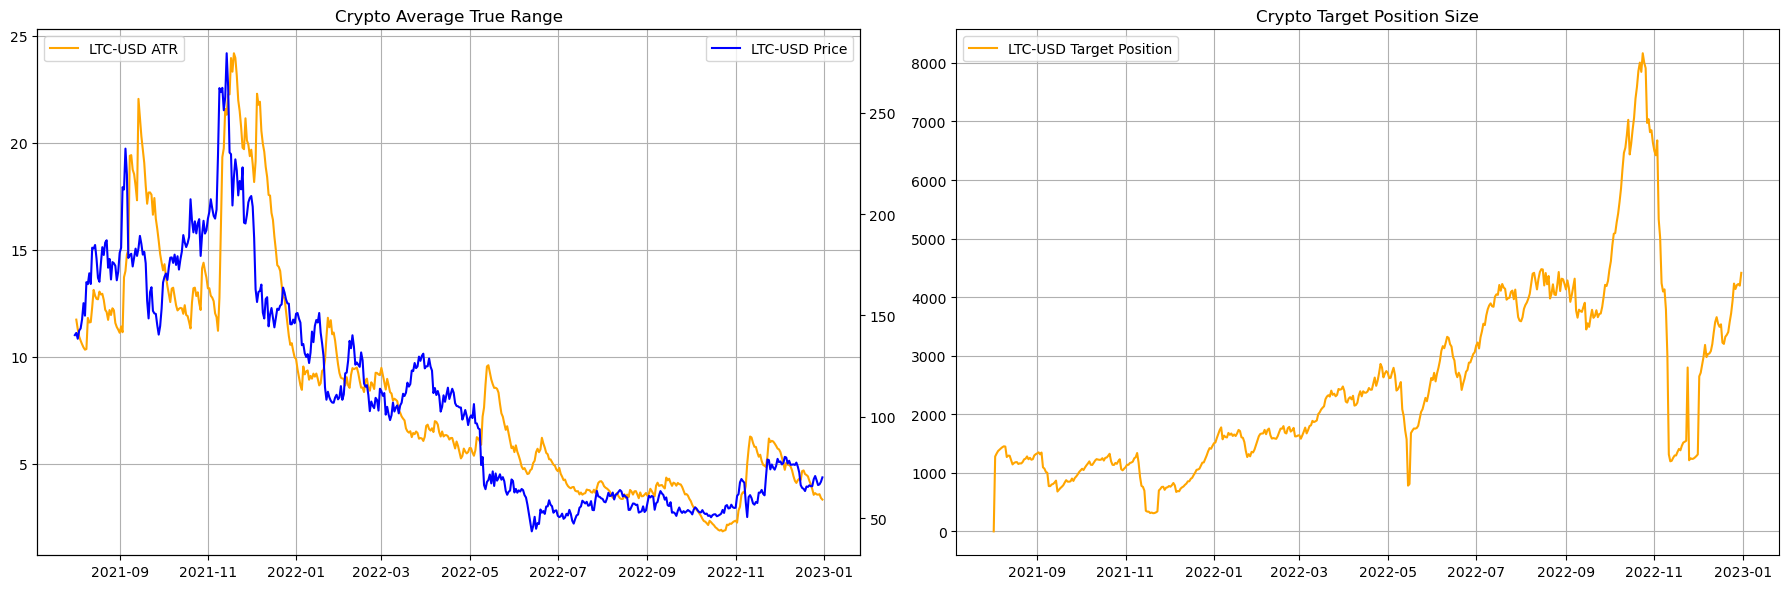

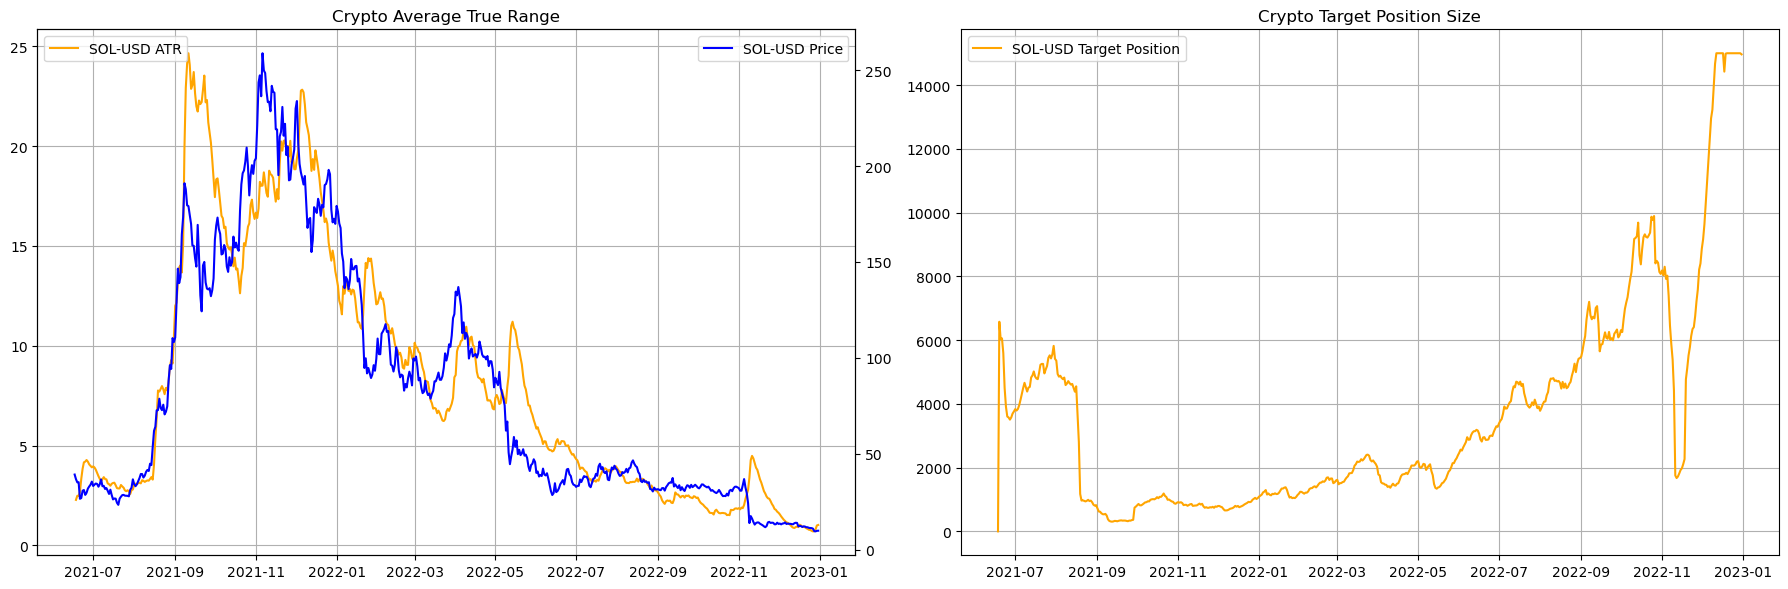

In [473]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.05, risk_per_trade=0.05)
    df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_target_position_notional'], label=f'{ticker} Target Position', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'Crypto Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'Crypto Target Position Size')
    
    plt.tight_layout()

In [364]:
df_position.head(200)

BTC-USD_20_avg_true_range_price BTC-USD_volatility_regime  \
date                                                                    
2016-01-01                              NaN                      None   
2016-01-02                         9.230000                       Low   
2016-01-03                         8.841429                       Low   
2016-01-04                         9.021293                       Low   
2016-01-05                         8.583074                       Low   
2016-01-06                         8.302781                       Low   
2016-01-07                         8.017755                       Low   
2016-01-08                        10.064635                       Low   
2016-01-09                        10.712765                       Low   
2016-01-10                        10.486787                       Low   
2016-01-11                        10.290903                       Low   
2016-01-12                         9.955579                       Low   
2016-01-13                        10.684571                       Low   
2016-01-14                        10.857469                       Low   
2016-01-15                        10.515806                       Low   
2016-01-16                        16.465729                       Low   
2016-01-17                        18.714707                       Low   
2016-01-18                        18.741878                       Low   
2016-01-19                        18.480747                       Low   
2016-01-20                        18.196866                       Low   
2016-01-21                        21.806688                       Low   
2016-01-22                        21.784147                       Low   
2016-01-23                        23.531371                       Low   
2016-01-24                        22.830288                       Low   
2016-01-25                        22.507403                       Low   
2016-01-26                        21.948603                       Low   
2016-01-27                        20.736355                       Low   
2016-01-28                        19.378607                       Low   
2016-01-29                        19.235882                       Low   
2016-01-30                        19.480084                       Low   
2016-01-31                        18.295314                       Low   
2016-02-01                        18.219570                       Low   
2016-02-02                        17.697706                       Low   
2016-02-03                        16.320782                       Low   
2016-02-04                        15.469279                       Low   
2016-02-05                        16.080776                       Low   
2016-02-06                        15.155940                       Low   
2016-02-07                        15.092517                       Low   
2016-02-08                        14.280849                       Low   
2016-02-09                        13.763625                       Low   
2016-02-10                        12.909947                       Low   
2016-02-11                        12.772809                       Low   
2016-02-12                        13.413494                       Low   
2016-02-13                        12.573161                       Low   
2016-02-14                        12.710003                       Low   
2016-02-15                        13.015717                       Low   
2016-02-16                        13.210410                       Low   
2016-02-17                        13.618943                       Low   
2016-02-18                        13.697139                       Low   
2016-02-19                        13.172649                       Low   
2016-02-20                        12.489540                       Low   
2016-02-21                        13.580060                       Low   
2016-02-22                        14.447673                       Low 

In [322]:
df_strategy.head(20)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                      
2016-01-11   449.19                                                  0    
2016-01-12   434.01                                                  0    
2016-01-13   432.77                                                  0    
2016-01-14   430.03                                                  0    
2016-01-15   357.53                                                  0    
2016-01-16   388.70                                                  0    
2016-01-17   378.46                                                  0    
2016-01-18   384.89                                                  0    
2016-01-19   375.27                                                  0    
2016-01-20   418.54                                                  0    
2016-01-21   409.38                                                  0    
2016-01-22   382.90                                                  0    
2016-01-23   387.50                                                  0    
2016-01-24   403.05                                                  0    
2016-01-25   391.40                                                  0    
2016-01-26   391.54                                                  0    
2016-01-27   394.79                                                  0    
2016-01-28   379.61                                                  0    
2016-01-29   378.68                                                  0    
2016-01-30   378.46                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2016-01-11                                               -0.0              
2016-01-12                                               -0.0              
2016-01-13                                               -0.0              
2016-01-14                                               -0.0              
2016-01-15                                               -0.0              
2016-01-16                                                0.0              
2016-01-17                                               -0.0              
2016-01-18                                                0.0              
2016-01-19                                               -0.0              
2016-01-20                                                0.0              
2016-01-21                                               -0.0              
2016-01-22                                               -0.0              
2016-01-23                                                0.0              
2016-01-24                                                0.0              
2016-01-25                                               -0.0              
2016-01-26                                                0.0              
2016-01-27                                                0.0              
2016-01-28                                               -0.0              
2016-01-29                                               -0.0              
2016-01-30                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2016-01-11                                                NaN             
2016-01-12                                                0.0             
2016-01-13                                                0.0             
2016-01-14                                                0.0             
2016-01-15                                                0.0             
2016-01-16                                                0.0             
2016-01-17                                                0.0             
2016-01-18   

In [479]:
def apply_position_sizing_strategy(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                   long_only=False, include_signal_strength=False, rolling_atr_window=20, position_size_atr_multiplier=0.01, risk_per_trade=0.02, initial_capital=15000,
                                   use_coinbase_data=True, high_volatility_threshold=1.5, stop_loss_multiplier=1.5, take_profit_multiplier=3, apply_position_sizing_pyramid=True,
                                   position_sizing_pyramid_factor=0.5):

    close_price_col = f'{ticker}'
    t_1_close_price_col = f'{ticker}_t_1'
    signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
    target_position_notional_col = f'{ticker}_target_position_notional'
    actual_position_notional_col = f'{ticker}_actual_position_notional'
    actual_position_shares_col = f'{ticker}_actual_position_share_count'
    actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
    atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
    
    df = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                     long_only=long_only, include_signal_strength=include_signal_strength)
    trend_cols = [close_price_col, signal_col, returns_col, trades_col]
    df = df[trend_cols]
    df[t_1_close_price_col] = df[close_price_col].shift(1)
    
    df_position = get_volatility_scaled_target_position_size(start_date=start_date, end_date=end_date, ticker=ticker, rolling_atr_window=rolling_atr_window,
                                                             position_size_atr_multiplier=position_size_atr_multiplier, risk_per_trade=risk_per_trade,
                                                             initial_capital=initial_capital, high_volatility_threshold=high_volatility_threshold,
                                                             use_coinbase_data=use_coinbase_data, price_or_returns_calc=price_or_returns_calc)
    df = pd.merge(df, df_position, left_index=True, right_index=True, how='left')

    if apply_position_sizing_pyramid:
        ## Apply Position Sizing Pyramid Factor
        df[target_position_notional_col] = np.where((df[signal_col] == 1) | (df[signal_col] == -1), df[target_position_notional_col] * (1 + position_sizing_pyramid_factor),
                                                    df[target_position_notional_col])
    df[actual_position_notional_col] = 0.0
    df[actual_position_entry_price_col] = 0.0
    df[actual_position_shares_col] = 0.0
    df['portfolio_value'] = initial_capital
    df['event'] = np.nan
    
    position = 0
    entry_price = None
    
    for i in range(1, len(df)):
        ## Taking a New Long position
        if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Long Position: {df.index[i]}')
            # position = df[position_col][i]
            # entry_price = df[close_price_col][i]
            # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
            # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Long Position'
            
        ## Taking a New Short position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Short Position'
            
        ## Amending an Existing Long Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Amending an Existing Long Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Long Position'
            # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
            
        ## Amending an Existing Short Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Amending an Existing Short Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Short Position'
            
        ## Taking a New Long Position with an Existing Short Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Take a New Long Position with an Existing Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Long with Existing Short Position'
            
        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Take a New Short Position with an Existing Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Short with Existing Long Position'
        
        ## Closing a Long Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Closing a Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i]
            df['event'][i] = 'Closing Long Position'
            
        ## Closing a Short Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Closing a Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + (df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i])
            df['event'][i] = 'Closing Short Position'
    
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
            # print(f'Other: {df_test.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'No Event'
        
        
            
        # elif df[signal_col][i] == -1 and position > 0:
        #     initial_capital += position * (df[close_price_col][i] - entry_price)
        #     position = 0
        #     entry_price = None
        
        # # Stop-loss and take-profit logic
        # if position > 0:
        #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
        #         initial_capital += position * (df[close_price_col][i] - entry_price)
        #         position = 0
        #         entry_price = None
        
        # df.at[df.index[i], 'Capital'] = initial_capital

    return df

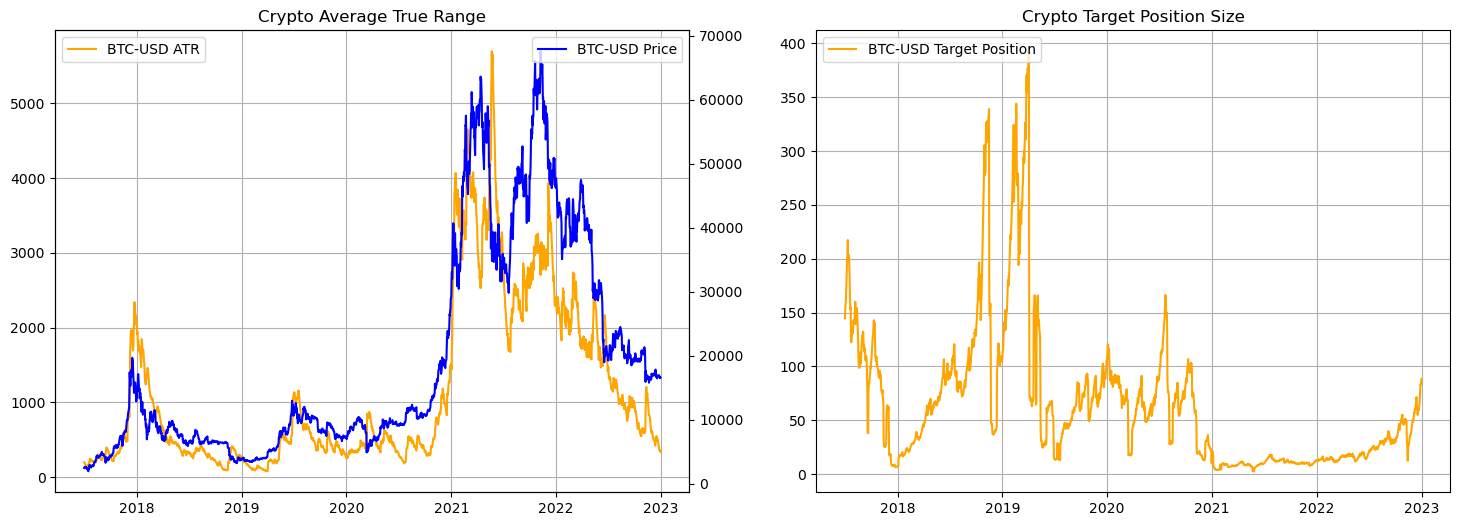

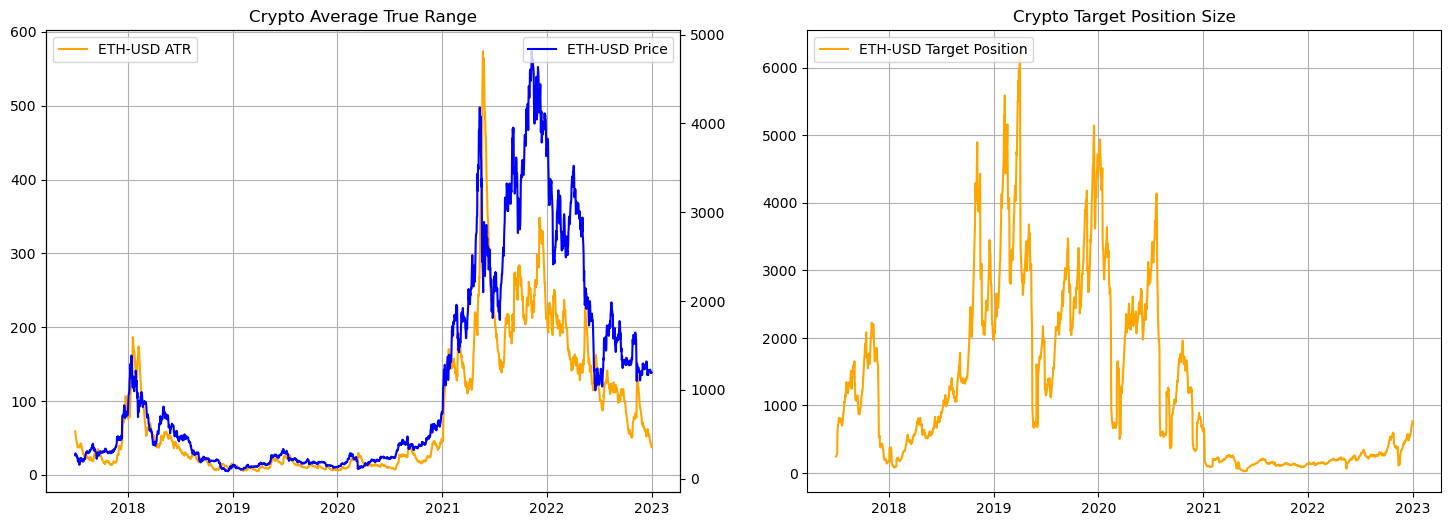

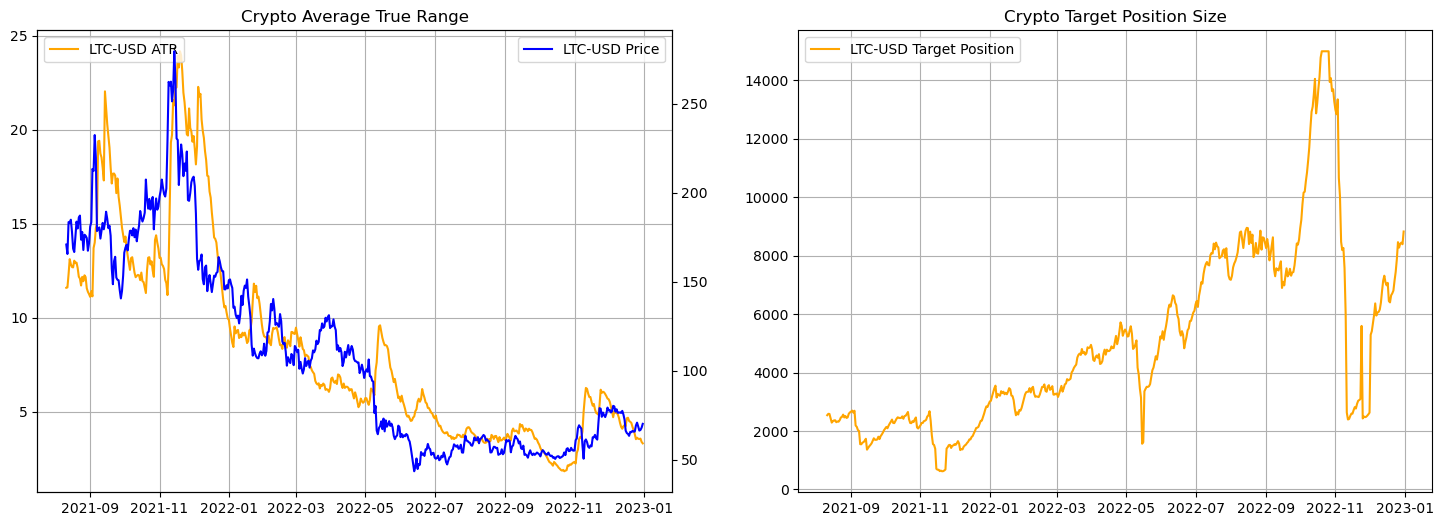

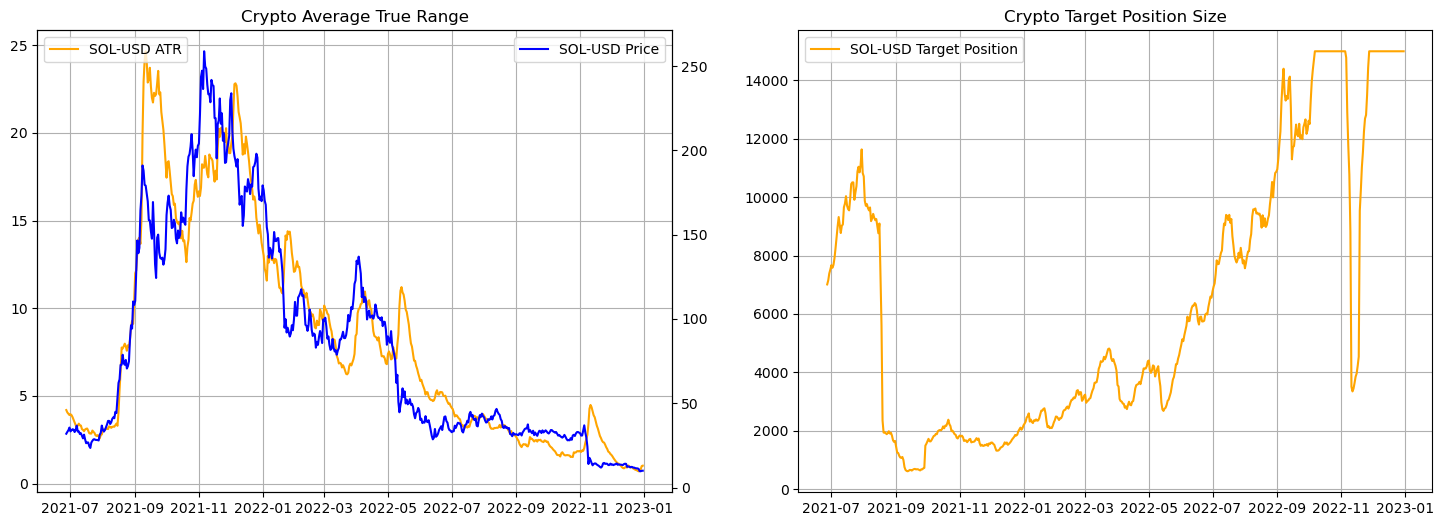

In [500]:
all_ticker_non_pyramid_df = {}
for ticker in ticker_list:
    df_strategy = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, rolling_atr_window=20, position_size_atr_multiplier=0.01,
                                                 risk_per_trade=0.02, position_sizing_pyramid_factor=False)
    df_strategy = df_strategy[df_strategy.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_df[ticker] = df_strategy
    
    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    
    _ = strategy_atr_ax.plot(df_strategy.index, df_strategy[f'{ticker}_{rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy.index, df_strategy[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy.index, df_strategy[f'{ticker}_target_position_notional'], label=f'{ticker} Target Position', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'Crypto Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'Crypto Target Position Size')

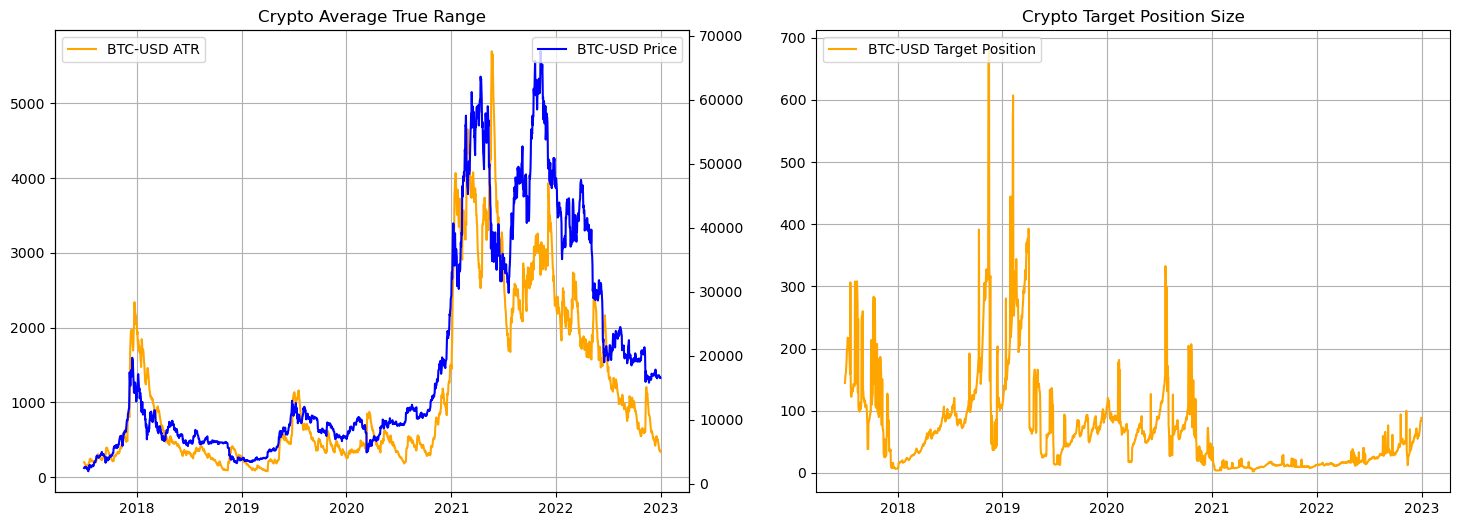

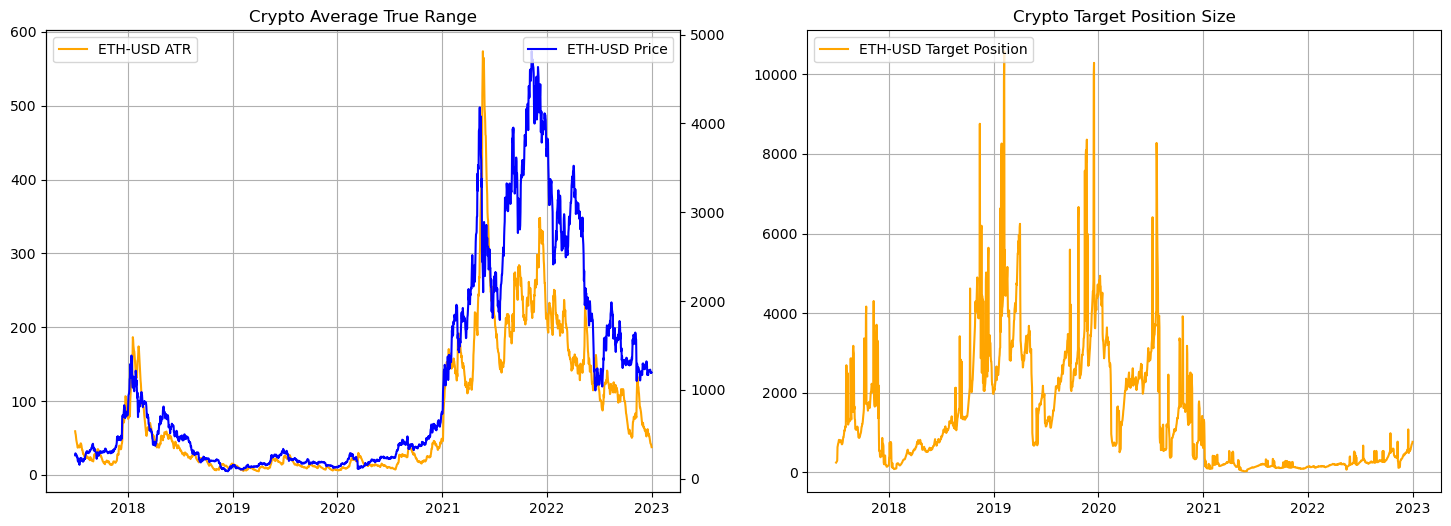

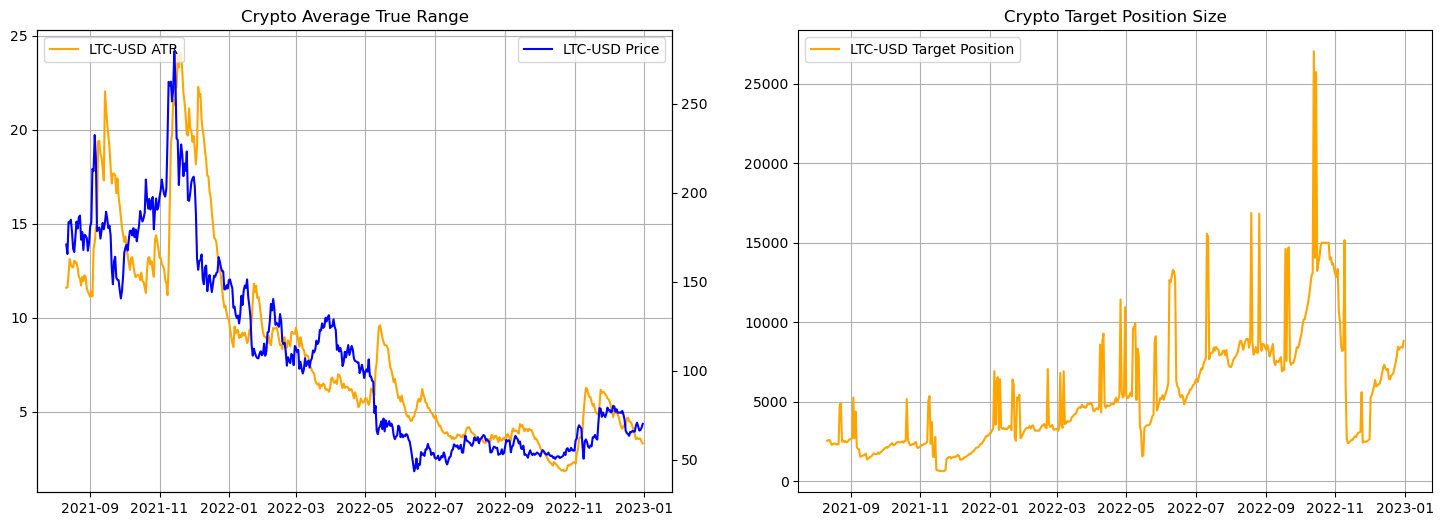

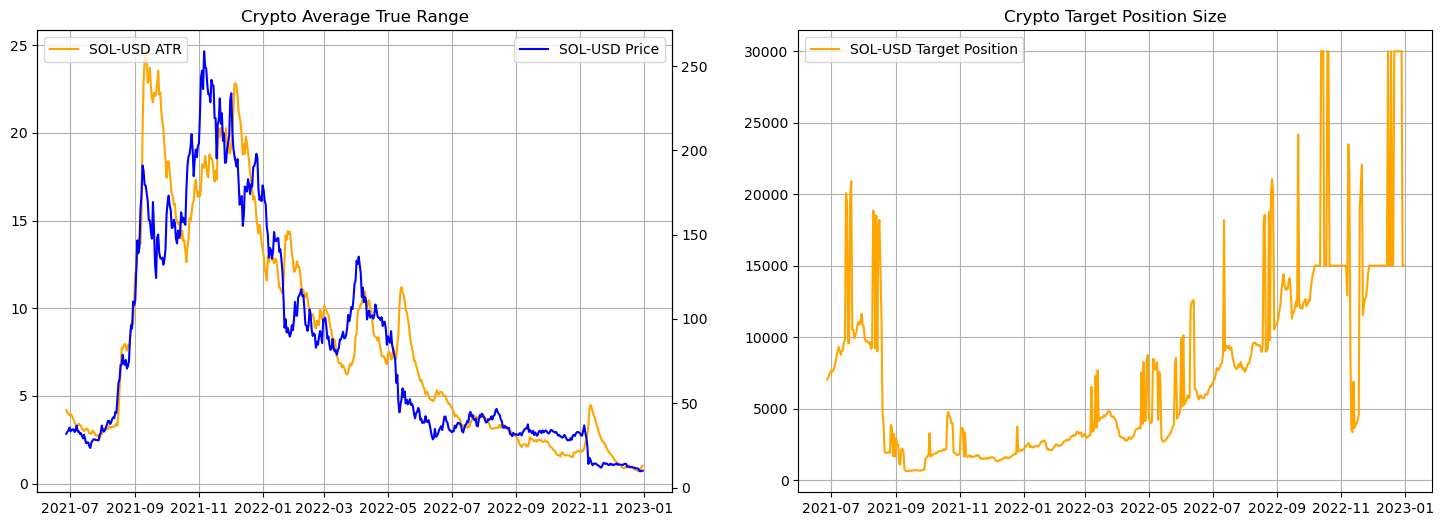

In [502]:
all_ticker_pyramid_df = {}
for ticker in ticker_list:
    df_strategy = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, rolling_atr_window=20, position_size_atr_multiplier=0.01,
                                                 risk_per_trade=0.02, position_sizing_pyramid_factor=True)
    df_strategy = df_strategy[df_strategy.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_pyramid_df[ticker] = df_strategy
    
    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    
    _ = strategy_atr_ax.plot(df_strategy.index, df_strategy[f'{ticker}_{rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy.index, df_strategy[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy.index, df_strategy[f'{ticker}_target_position_notional'], label=f'{ticker} Target Position', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'Crypto Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'Crypto Target Position Size')

In [484]:
df_strategy.shape

(2547, 13)

In [486]:
df_strategy.head(20)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                      
2016-01-11   449.19                                                  0    
2016-01-12   434.01                                                  0    
2016-01-13   432.77                                                  0    
2016-01-14   430.03                                                  0    
2016-01-15   357.53                                                  0    
2016-01-16   388.70                                                  0    
2016-01-17   378.46                                                  0    
2016-01-18   384.89                                                  0    
2016-01-19   375.27                                                  0    
2016-01-20   418.54                                                  0    
2016-01-21   409.38                                                  0    
2016-01-22   382.90                                                  0    
2016-01-23   387.50                                                  0    
2016-01-24   403.05                                                  0    
2016-01-25   391.40                                                  0    
2016-01-26   391.54                                                  0    
2016-01-27   394.79                                                  0    
2016-01-28   379.61                                                  0    
2016-01-29   378.68                                                  0    
2016-01-30   378.46                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2016-01-11                                               -0.0              
2016-01-12                                               -0.0              
2016-01-13                                               -0.0              
2016-01-14                                               -0.0              
2016-01-15                                               -0.0              
2016-01-16                                                0.0              
2016-01-17                                               -0.0              
2016-01-18                                                0.0              
2016-01-19                                               -0.0              
2016-01-20                                                0.0              
2016-01-21                                               -0.0              
2016-01-22                                               -0.0              
2016-01-23                                                0.0              
2016-01-24                                                0.0              
2016-01-25                                               -0.0              
2016-01-26                                                0.0              
2016-01-27                                                0.0              
2016-01-28                                               -0.0              
2016-01-29                                               -0.0              
2016-01-30                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2016-01-11                                                NaN             
2016-01-12                                                0.0             
2016-01-13                                                0.0             
2016-01-14                                                0.0             
2016-01-15                                                0.0             
2016-01-16                                                0.0             
2016-01-17                                                0.0             
2016-01-18   

In [419]:
df_strategy.tail(20)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                       
2022-12-12  17211.66                                                  0    
2022-12-13  17773.18                                                  0    
2022-12-14  17804.97                                                  0    
2022-12-15  17357.96                                                  0    
2022-12-16  16632.64                                                  0    
2022-12-17  16782.25                                                  0    
2022-12-18  16741.16                                                  0    
2022-12-19  16439.74                                                  0    
2022-12-20  16897.65                                                  0    
2022-12-21  16826.56                                                  0    
2022-12-22  16815.51                                                  0    
2022-12-23  16777.21                                                  0    
2022-12-24  16837.12                                                  0    
2022-12-25  16829.02                                                  0    
2022-12-26  16917.96                                                  0    
2022-12-27  16698.73                                                  0    
2022-12-28  16539.66                                                  0    
2022-12-29  16627.54                                                  0    
2022-12-30  16600.10                                                  0    
2022-12-31  16530.35                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2022-12-12                                                0.0              
2022-12-13                                                0.0              
2022-12-14                                                0.0              
2022-12-15                                               -0.0              
2022-12-16                                               -0.0              
2022-12-17                                                0.0              
2022-12-18                                               -0.0              
2022-12-19                                               -0.0              
2022-12-20                                                0.0              
2022-12-21                                               -0.0              
2022-12-22                                               -0.0              
2022-12-23                                               -0.0              
2022-12-24                                                0.0              
2022-12-25                                               -0.0              
2022-12-26                                                0.0              
2022-12-27                                               -0.0              
2022-12-28                                               -0.0              
2022-12-29                                                0.0              
2022-12-30                                               -0.0              
2022-12-31                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2022-12-12                                                0.0             
2022-12-13                                                0.0             
2022-12-14                                                0.0             
2022-12-15                                                0.0             
2022-12-16                                                0.0             
2022-12-17                                                0.0             
2022-12-18                                                0.0      

In [314]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
close_price_col = f'{ticker}'
t_1_close_price_col = f'{ticker}_t_1'
signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
target_position_notional_col = f'{ticker}_target_position_notional'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_shares_col = f'{ticker}_actual_position_share_count'
actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
initial_capital = 15000

df_test = df_strategy.copy()
# df_test = df_test.head(200)
df_test[actual_position_notional_col] = 0.0
df_test[actual_position_entry_price_col] = 0.0
df_test[actual_position_shares_col] = 0.0
df_test['initial_capital'] = initial_capital
df_test['event'] = np.nan

In [316]:
for i in range(1, len(df_test)):
    ## Taking a New Long position
    if (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Long Position: {df_test.index[i]}')
        # position = df[position_col][i]
        # entry_price = df[close_price_col][i]
        # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
        # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Long Position'
        
    ## Taking a New Short position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Short Position'
        
    ## Amending an Existing Long Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Amending an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Long Position'
        # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
        
    ## Amending an Existing Short Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Amending an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Short Position'
        
    ## Taking a New Long Position with an Existing Short Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Take a New Long Position with an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Long with Existing Short Position'
        
    ## Taking a New Short Position with an Existing Long Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Take a New Short Position with an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Short with Existing Long Position'
    
    ## Closing a Long Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Closing a Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i]
        df_test['event'][i] = 'Closing Long Position'
        
    ## Closing a Short Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Closing a Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])
        df_test['event'][i] = 'Closing Short Position'

    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 0):
        print(f'Other: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'No Event'

Other: 2016-01-12
Other: 2016-01-13
Other: 2016-01-14
Other: 2016-01-15
Other: 2016-01-16
Other: 2016-01-17
Other: 2016-01-18
Other: 2016-01-19
Other: 2016-01-20
Other: 2016-01-21
Other: 2016-01-22
Other: 2016-01-23
Other: 2016-01-24
Other: 2016-01-25
Other: 2016-01-26
Other: 2016-01-27
Other: 2016-01-28
Other: 2016-01-29
Other: 2016-01-30
Other: 2016-01-31
Other: 2016-02-01
Other: 2016-02-02
Other: 2016-02-03
Other: 2016-02-04
Other: 2016-02-05
Other: 2016-02-06
Other: 2016-02-07
Other: 2016-02-08
Other: 2016-02-09
Other: 2016-02-10
Other: 2016-02-11
Other: 2016-02-12
Other: 2016-02-13
Other: 2016-02-14
Other: 2016-02-15
Other: 2016-02-16
Other: 2016-02-17
Other: 2016-02-18
Other: 2016-02-19
Other: 2016-02-20
Other: 2016-02-21
Other: 2016-02-22
Other: 2016-02-23
Other: 2016-02-24
Other: 2016-02-25
Other: 2016-02-26
Other: 2016-02-27
Other: 2016-02-28
Other: 2016-02-29
Other: 2016-03-01
Other: 2016-03-02
Other: 2016-03-03
Other: 2016-03-04
Other: 2016-03-05
Other: 2016-03-06
Other: 201

In [318]:
initial_capital = 15000
df_test['portfolio_value'] = initial_capital * (1 + df_test['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns']).cumprod()
df_test.head(1500)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                       
2016-01-11    449.19                                                  0    
2016-01-12    434.01                                                  0    
2016-01-13    432.77                                                  0    
2016-01-14    430.03                                                  0    
2016-01-15    357.53                                                  0    
2016-01-16    388.70                                                  0    
2016-01-17    378.46                                                  0    
2016-01-18    384.89                                                  0    
2016-01-19    375.27                                                  0    
2016-01-20    418.54                                                  0    
2016-01-21    409.38                                                  0    
2016-01-22    382.90                                                  0    
2016-01-23    387.50                                                  0    
2016-01-24    403.05                                                  0    
2016-01-25    391.40                                                  0    
2016-01-26    391.54                                                  0    
2016-01-27    394.79                                                  0    
2016-01-28    379.61                                                  0    
2016-01-29    378.68                                                  0    
2016-01-30    378.46                                                  0    
2016-01-31    367.95                                                  0    
2016-02-01    371.33                                                  0    
2016-02-02    372.93                                                  0    
2016-02-03    368.87                                                  0    
2016-02-04    387.99                                                  0    
2016-02-05    384.50                                                  0    
2016-02-06    375.44                                                  0    
2016-02-07    377.49                                                  0    
2016-02-08    371.14                                                  0    
2016-02-09    372.68                                                  0    
2016-02-10    378.44                                                  0    
2016-02-11    378.23                                                  0    
2016-02-12    382.05                                                  0    
2016-02-13    391.00                                                  0    
2016-02-14    406.59                                                  0    
2016-02-15    398.95                                                  0    
2016-02-16    407.42                                                  0    
2016-02-17    415.20                                                  0    
2016-02-18    421.19                                                  0    
2016-02-19    420.72                                                  0    
2016-02-20    437.46                                                  0    
2016-02-21    438.56                                                  0    
2016-02-22    437.55                                                  0    
2016-02-23    419.97                                                  0    
2016-02-24    423.94                                                  0    
2016-02-25    423.54                                                  0    
2016-02-26    430.85                                                  0    
2016-02-27    433.12                                                  0    
2016-02-28    433.73                                                  0    
2016-02-29    436.44                                                  0    
2016-03-01    433.08                                         

In [276]:
i = 972
df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])

26870.761459590136

In [320]:
df_test.tail(200)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                       
2022-06-15  22562.33                                                  0    
2022-06-16  20372.00                                                 -1    
2022-06-17  20447.86                                                  0    
2022-06-18  18948.89                                                 -1    
2022-06-19  20552.44                                                  0    
2022-06-20  20549.75                                                  0    
2022-06-21  20696.96                                                  0    
2022-06-22  19968.46                                                  0    
2022-06-23  21104.45                                                  0    
2022-06-24  21223.72                                                  0    
2022-06-25  21478.04                                                  0    
2022-06-26  21027.92                                                  0    
2022-06-27  20725.17                                                  0    
2022-06-28  20252.89                                                  0    
2022-06-29  20094.79                                                  0    
2022-06-30  19985.62                                                  0    
2022-07-01  19252.76                                                  0    
2022-07-02  19224.03                                                  0    
2022-07-03  19291.33                                                  0    
2022-07-04  20211.35                                                  0    
2022-07-05  20153.51                                                  0    
2022-07-06  20542.67                                                  0    
2022-07-07  21614.60                                                  0    
2022-07-08  21582.20                                                  0    
2022-07-09  21583.99                                                  0    
2022-07-10  20850.65                                                  0    
2022-07-11  19942.43                                                  0    
2022-07-12  19303.65                                                  0    
2022-07-13  20220.23                                                  0    
2022-07-14  20577.02                                                  0    
2022-07-15  20827.55                                                  0    
2022-07-16  21189.68                                                  0    
2022-07-17  20791.74                                                  0    
2022-07-18  22427.56                                                  0    
2022-07-19  23395.06                                                  0    
2022-07-20  23226.99                                                  0    
2022-07-21  23153.96                                                  0    
2022-07-22  22687.68                                                  0    
2022-07-23  22450.69                                                  0    
2022-07-24  22583.43                                                  0    
2022-07-25  21313.41                                                  0    
2022-07-26  21261.57                                                  0    
2022-07-27  22962.59                                                  0    
2022-07-28  23851.70                                                  0    
2022-07-29  23784.50                                                  0    
2022-07-30  23650.13                                                  0    
2022-07-31  23307.44                                                  0    
2022-08-01  23273.86                                                  0    
2022-08-02  22989.40                                                  0    
2022-08-03  22825.00                                                  0    
2022-08-04  22623.94                                         

In [46]:
df_strategy['BTC-USD_strategy_position'] = df_strategy['BTC-USD_position_size'] * df_strategy['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal']

In [34]:
strategy_cols = ['BTC-USD', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', 'Capital', 'BTC-USD_strategy_position']

In [36]:
trend_cols = ['BTC-USD','BTC-USD_pct_returns','BTC-USD_50_mavg','BTC-USD_90_mavg','BTC-USD_130_mavg','BTC-USD_170_mavg','BTC-USD_210_mavg','BTC-USD_250_mavg',
              'BTC-USD_trend_signal','BTC-USD_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']

In [38]:
sorted(df_trend.columns)

NameError: name 'df_trend' is not defined

In [44]:
df_trend[trend_cols].head(200)

BTC-USD  BTC-USD_pct_returns  BTC-USD_50_mavg  BTC-USD_90_mavg  \
date                                                                         
2016-01-11   449.19            -0.001778       443.092417       442.692652   
2016-01-12   434.01            -0.033794       442.158208       441.877429   
2016-01-13   432.77            -0.002857       441.250326       441.079690   
2016-01-14   430.03            -0.006331       440.224257       440.171421   
2016-01-15   357.53            -0.168593       433.037466       433.764251   
2016-01-16   388.70             0.087181       429.359592       430.454304   
2016-01-17   378.46            -0.026344       425.314304       426.822292   
2016-01-18   384.89             0.016990       422.225888       424.026981   
2016-01-19   375.27            -0.024994       418.767073       420.915744   
2016-01-20   418.54             0.115304       418.750904       420.770232   
2016-01-21   409.38            -0.021886       418.104305       420.098955   
2016-01-22   382.90            -0.064683       415.745443       417.984786   
2016-01-23   387.50             0.012014       413.904031       416.310567   
2016-01-24   403.05             0.040129       413.214338       415.605525   
2016-01-25   391.40            -0.028905       411.861119       414.357484   
2016-01-26   391.54             0.000358       410.628651       413.214813   
2016-01-27   394.79             0.008301       409.688201       412.317341   
2016-01-28   379.61            -0.038451       407.937545       410.765648   
2016-01-29   378.68            -0.002450       406.266386       409.281248   
2016-01-30   378.46            -0.000581       404.706051       407.889151   
2016-01-31   367.95            -0.027770       402.677787       406.126110   
2016-02-01   371.33             0.009186       400.975144       404.623408   
2016-02-02   372.93             0.004309       399.474541       403.283123   
2016-02-03   368.87            -0.010887       397.860066       401.856794   
2016-02-04   387.99             0.051834       397.346346       401.293030   
2016-02-05   384.50            -0.008995       396.686188       400.622815   
2016-02-06   375.44            -0.023563       395.607504       399.635467   
2016-02-07   377.49             0.005460       394.698172       398.781912   
2016-02-08   371.14            -0.016822       393.528605       397.733867   
2016-02-09   372.68             0.004149       392.504241       396.798849   
2016-02-10   378.44             0.015456       391.820003       396.124045   
2016-02-11   378.23            -0.000555       391.165017       395.475903   
2016-02-12   382.05             0.010100       390.729618       394.996432   
2016-02-13   391.00             0.023426       390.742424       394.855643   
2016-02-14   406.59             0.039872       391.486934       395.263622   
2016-02-15   398.95            -0.018790       391.834844       395.390171   
2016-02-16   407.42             0.021231       392.556048       395.798102   
2016-02-17   415.20             0.019096       393.596552       396.448263   
2016-02-18   421.19             0.014427       394.856006       397.267911   
2016-02-19   420.72            -0.001116       396.028983       398.036267   
2016-02-20   437.46             0.039789       397.896493       399.314118   
2016-02-21   438.56             0.002515       399.718730       400.573068   
2016-02-22   437.55            -0.002303       401.404611       401.747371   
2016-02-23   419.97            -0.040178       402.227543       402.320476   
2016-02-24   423.94             0.009453       403.185078       402.994033   
2016-02-25   423.54            -0.000944       404.078382       403.628323   
2016-02-26   430.85             0.017259       405.247829       404.461295   
2016-02-27   433.12             0.005269       406.459937       405.330744   
2016-02-28   433.73             0.001408       407.640814       406.185179   
2016-02-29   436.44             0.

In [40]:
df_strategy[strategy_cols].head(200)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                      
2016-01-11   449.19                                                  0    
2016-01-12   434.01                                                  0    
2016-01-13   432.77                                                  0    
2016-01-14   430.03                                                  0    
2016-01-15   357.53                                                  0    
2016-01-16   388.70                                                  0    
2016-01-17   378.46                                                  0    
2016-01-18   384.89                                                  0    
2016-01-19   375.27                                                  0    
2016-01-20   418.54                                                  0    
2016-01-21   409.38                                                  0    
2016-01-22   382.90                                                  0    
2016-01-23   387.50                                                  0    
2016-01-24   403.05                                                  0    
2016-01-25   391.40                                                  0    
2016-01-26   391.54                                                  0    
2016-01-27   394.79                                                  0    
2016-01-28   379.61                                                  0    
2016-01-29   378.68                                                  0    
2016-01-30   378.46                                                  0    
2016-01-31   367.95                                                  0    
2016-02-01   371.33                                                  0    
2016-02-02   372.93                                                  0    
2016-02-03   368.87                                                  0    
2016-02-04   387.99                                                  0    
2016-02-05   384.50                                                  0    
2016-02-06   375.44                                                  0    
2016-02-07   377.49                                                  0    
2016-02-08   371.14                                                  0    
2016-02-09   372.68                                                  0    
2016-02-10   378.44                                                  0    
2016-02-11   378.23                                                  0    
2016-02-12   382.05                                                  0    
2016-02-13   391.00                                                  0    
2016-02-14   406.59                                                  0    
2016-02-15   398.95                                                  0    
2016-02-16   407.42                                                  0    
2016-02-17   415.20                                                  0    
2016-02-18   421.19                                                  0    
2016-02-19   420.72                                                  0    
2016-02-20   437.46                                                  0    
2016-02-21   438.56                                                  0    
2016-02-22   437.55                                                  0    
2016-02-23   419.97                                                  0    
2016-02-24   423.94                                                  0    
2016-02-25   423.54                                                  0    
2016-02-26   430.85                                                  0    
2016-02-27   433.12                                                  0    
2016-02-28   433.73                                                  0    
2016-02-29   436.44                                                  0    
2016-03-01   433.08                                                  0    
2016-03-02   420.39                  

In [48]:
df_strategy[strategy_cols].tail(200)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                       
2022-06-15  22562.33                                                  0    
2022-06-16  20372.00                                                 -1    
2022-06-17  20447.86                                                  0    
2022-06-18  18948.89                                                 -1    
2022-06-19  20552.44                                                  0    
2022-06-20  20549.75                                                  0    
2022-06-21  20696.96                                                  0    
2022-06-22  19968.46                                                  0    
2022-06-23  21104.45                                                  0    
2022-06-24  21223.72                                                  0    
2022-06-25  21478.04                                                  0    
2022-06-26  21027.92                                                  0    
2022-06-27  20725.17                                                  0    
2022-06-28  20252.89                                                  0    
2022-06-29  20094.79                                                  0    
2022-06-30  19985.62                                                  0    
2022-07-01  19252.76                                                  0    
2022-07-02  19224.03                                                  0    
2022-07-03  19291.33                                                  0    
2022-07-04  20211.35                                                  0    
2022-07-05  20153.51                                                  0    
2022-07-06  20542.67                                                  0    
2022-07-07  21614.60                                                  0    
2022-07-08  21582.20                                                  0    
2022-07-09  21583.99                                                  0    
2022-07-10  20850.65                                                  0    
2022-07-11  19942.43                                                  0    
2022-07-12  19303.65                                                  0    
2022-07-13  20220.23                                                  0    
2022-07-14  20577.02                                                  0    
2022-07-15  20827.55                                                  0    
2022-07-16  21189.68                                                  0    
2022-07-17  20791.74                                                  0    
2022-07-18  22427.56                                                  0    
2022-07-19  23395.06                                                  0    
2022-07-20  23226.99                                                  0    
2022-07-21  23153.96                                                  0    
2022-07-22  22687.68                                                  0    
2022-07-23  22450.69                                                  0    
2022-07-24  22583.43                                                  0    
2022-07-25  21313.41                                                  0    
2022-07-26  21261.57                                                  0    
2022-07-27  22962.59                                                  0    
2022-07-28  23851.70                                                  0    
2022-07-29  23784.50                                                  0    
2022-07-30  23650.13                                                  0    
2022-07-31  23307.44                                                  0    
2022-08-01  23273.86                                                  0    
2022-08-02  22989.40                                                  0    
2022-08-03  22825.00                                                  0    
2022-08-04  22623.94                                         

In [48]:
df_strategy.head(200)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                      
2016-01-11   449.19                                                  0    
2016-01-12   434.01                                                  0    
2016-01-13   432.77                                                  0    
2016-01-14   430.03                                                  0    
2016-01-15   357.53                                                  0    
2016-01-16   388.70                                                  0    
2016-01-17   378.46                                                  0    
2016-01-18   384.89                                                  0    
2016-01-19   375.27                                                  0    
2016-01-20   418.54                                                  0    
2016-01-21   409.38                                                  0    
2016-01-22   382.90                                                  0    
2016-01-23   387.50                                                  0    
2016-01-24   403.05                                                  0    
2016-01-25   391.40                                                  0    
2016-01-26   391.54                                                  0    
2016-01-27   394.79                                                  0    
2016-01-28   379.61                                                  0    
2016-01-29   378.68                                                  0    
2016-01-30   378.46                                                  0    
2016-01-31   367.95                                                  0    
2016-02-01   371.33                                                  0    
2016-02-02   372.93                                                  0    
2016-02-03   368.87                                                  0    
2016-02-04   387.99                                                  0    
2016-02-05   384.50                                                  0    
2016-02-06   375.44                                                  0    
2016-02-07   377.49                                                  0    
2016-02-08   371.14                                                  0    
2016-02-09   372.68                                                  0    
2016-02-10   378.44                                                  0    
2016-02-11   378.23                                                  0    
2016-02-12   382.05                                                  0    
2016-02-13   391.00                                                  0    
2016-02-14   406.59                                                  0    
2016-02-15   398.95                                                  0    
2016-02-16   407.42                                                  0    
2016-02-17   415.20                                                  0    
2016-02-18   421.19                                                  0    
2016-02-19   420.72                                                  0    
2016-02-20   437.46                                                  0    
2016-02-21   438.56                                                  0    
2016-02-22   437.55                                                  0    
2016-02-23   419.97                                                  0    
2016-02-24   423.94                                                  0    
2016-02-25   423.54                                                  0    
2016-02-26   430.85                                                  0    
2016-02-27   433.12                                                  0    
2016-02-28   433.73                                                  0    
2016-02-29   436.44                                                  0    
2016-03-01   433.08                                                  0    
2016-03-02   420.39                  

In [50]:
df_position = position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', rolling_atr_window=20)

In [257]:
df_position.head()

BTC-USD_20_avg_true_range_price BTC-USD_volatility_regime  \
date                                                                    
2016-01-01                         9.230000                       Low   
2016-01-02                         8.841429                       Low   
2016-01-03                         9.021293                       Low   
2016-01-04                         8.583074                       Low   
2016-01-05                         8.302781                       Low   

            BTC-USD_position_size  
date                               
2016-01-01            3250.270856  
2016-01-02            3393.116820  
2016-01-03            3325.465829  
2016-01-04            3495.251161  
2016-01-05            3613.247001

In [259]:
df_returns.shape

(2547, 4)

In [261]:
df_returns = pd.merge(df_returns, df_position, left_index=True, right_index=True, how='left')

In [263]:
df_returns.shape

(2547, 7)

In [271]:
df_returns[df_returns['BTC-USD_volatility_regime'] == 'High']#.head(20)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                       
2016-05-28    523.25                                                  1    
2016-05-29    525.22                                                  1    
2016-05-30    532.55                                                  1    
2016-05-31    531.34                                                  0    
2016-06-01    534.84                                                  1    
2016-06-02    537.87                                                  1    
2016-06-03    571.25                                                  1    
2016-06-04    576.31                                                  1    
2016-06-05    575.17                                                  0    
2016-06-06    586.77                                                  1    
2016-06-07    579.71                                                  0    
2016-06-08    583.21                                                  0    
2016-06-09    577.46                                                  0    
2016-06-10    580.31                                                  0    
2016-06-11    609.50                                                  1    
2016-06-12    677.86                                                  1    
2016-06-13    706.01                                                  1    
2016-06-14    684.95                                                  0    
2016-06-15    698.78                                                  0    
2016-06-16    769.76                                                  1    
2016-06-17    752.26                                                  0    
2016-06-18    758.99                                                  0    
2016-06-19    768.76                                                  0    
2016-06-20    703.12                                                  0    
2016-06-21    667.66                                                  0    
2016-06-22    604.50                                                  0    
2016-06-23    631.10                                                  0    
2016-06-24    669.98                                                  0    
2016-06-25    673.71                                                  0    
2016-06-26    638.56                                                  0    
2016-06-27    657.87                                                  0    
2016-06-28    648.43                                                  0    
2016-06-29    639.42                                                  0    
2016-06-30    673.49                                                  0    
2016-07-01    678.19                                                  0    
2016-07-02    704.95                                                  0    
2016-07-03    663.55                                                  0    
2016-10-29    714.28                                                  1    
2016-10-30    697.41                                                  0    
2016-10-31    696.90                                                  0    
2016-11-01    730.70                                                  1    
2016-11-02    744.60                                                  1    
2016-11-03    690.00                                                  0    
2016-11-04    706.32                                                  0    
2016-11-05    706.99                                                  0    
2016-11-06    717.02                                                  0    
2016-11-07    706.42                                                  0    
2016-11-08    711.15                                                  0    
2016-11-09    720.97                                                  0    
2016-11-10    712.91                                                  0    
2016-11-11    716.90                                         

In [267]:
df_returns.groupby(['BTC-USD_volatility_regime']).size()

BTC-USD_volatility_regime
High     348
Low     2199
dtype: int64

In [123]:
# Simulate trading logic
position = 0
entry_price = 0
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
total_capital = 15000
risk_per_trade = 0.05
stop_loss_multiplier = 2
ticker = 'BTC-USD'
rolling_atr_window = 20


for i in range(1, len(df_returns)):
    current_price = df_returns[f'{ticker}_close'].iloc[i]
    atr = df_returns[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].iloc[i]
    signal = df_returns[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'].iloc[i]

    # Calculate stop-loss distance based on ATR
    stop_loss_distance = stop_loss_multiplier * atr
    risk_per_unit = current_price - (current_price - stop_loss_distance)

    # Calculate position size based on the risk
    position_size = (total_capital * risk_per_trade) / risk_per_unit

    if signal == 1 and position == 0:
        # Buy signal: go long
        position = position_size
        entry_price = current_price
        print(f"Buy: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == -1 and position > 0:
        # Sell signal: exit long position
        print(f"Sell: Closing long position at {current_price:.2f} USD")
        position = 0  # Reset position

    elif signal == -1 and position == 0:
        # Short signal: go short
        position = -position_size
        entry_price = current_price
        print(f"Short: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == 1 and position < 0:
        # Exit short position if a buy signal occurs
        print(f"Buy to cover: Closing short position at {current_price:.2f} USD")
        position = 0  # Reset position

Buy: 45.9130 units at 425.30 USD
Sell: Closing long position at 6188.00 USD
Short: 2.0285 units at 6154.69 USD
Buy to cover: Closing short position at 8860.23 USD
Buy: 0.8133 units at 8975.00 USD
Sell: Closing long position at 37644.10 USD
Short: 0.1971 units at 36537.22 USD


In [105]:
df_returns.head(20)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                      
2016-01-11   449.19                                                  0    
2016-01-12   434.01                                                  0    
2016-01-13   432.77                                                  0    
2016-01-14   430.03                                                  0    
2016-01-15   357.53                                                  0    
2016-01-16   388.70                                                  0    
2016-01-17   378.46                                                  0    
2016-01-18   384.89                                                  0    
2016-01-19   375.27                                                  0    
2016-01-20   418.54                                                  0    
2016-01-21   409.38                                                  0    
2016-01-22   382.90                                                  0    
2016-01-23   387.50                                                  0    
2016-01-24   403.05                                                  0    
2016-01-25   391.40                                                  0    
2016-01-26   391.54                                                  0    
2016-01-27   394.79                                                  0    
2016-01-28   379.61                                                  0    
2016-01-29   378.68                                                  0    
2016-01-30   378.46                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2016-01-11                                               -0.0              
2016-01-12                                               -0.0              
2016-01-13                                               -0.0              
2016-01-14                                               -0.0              
2016-01-15                                               -0.0              
2016-01-16                                                0.0              
2016-01-17                                               -0.0              
2016-01-18                                                0.0              
2016-01-19                                               -0.0              
2016-01-20                                                0.0              
2016-01-21                                               -0.0              
2016-01-22                                               -0.0              
2016-01-23                                                0.0              
2016-01-24                                                0.0              
2016-01-25                                               -0.0              
2016-01-26                                                0.0              
2016-01-27                                                0.0              
2016-01-28                                               -0.0              
2016-01-29                                               -0.0              
2016-01-30                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2016-01-11                                                NaN             
2016-01-12                                                0.0             
2016-01-13                                                0.0             
2016-01-14                                                0.0             
2016-01-15                                                0.0             
2016-01-16                                                0.0             
2016-01-17                                                0.0             
2016-01-18   

In [97]:
df_atr.head(20)

BTC-USD_low  BTC-USD_high  BTC-USD_open  BTC-USD_close  \
date                                                                 
2016-01-01       427.92        437.15        430.35         435.66   
2016-01-02       432.41        437.56        435.67         435.40   
2016-01-03       425.02        435.75        435.40         431.91   
2016-01-04       431.37        435.79        431.90         433.85   
2016-01-05       430.00        435.64        433.84         433.34   
2016-01-06       428.15        433.46        433.32         430.87   
2016-01-07       430.64        460.15        430.66         459.07   
2016-01-08       447.53        464.40        459.07         454.44   
2016-01-09       447.66        456.00        454.41         450.38   
2016-01-10       442.96        451.39        450.39         449.99   
2016-01-11       445.88        452.65        449.99         449.19   
2016-01-12       431.83        449.44        449.26         434.01   
2016-01-13       425.00        437.50        434.01         432.77   
2016-01-14       428.00        435.27        432.70         430.03   
2016-01-15       357.30        430.29        430.04         357.53   
2016-01-16       350.92        391.00        357.59         388.70   
2016-01-17       372.00        391.00        388.70         378.46   
2016-01-18       370.10        386.10        378.47         384.89   
2016-01-19       370.00        385.50        384.79         375.27   
2016-01-20       369.00        425.10        375.28         418.54   

            BTC-USD_volume  BTC-USD_high-low  BTC-USD_high-close  \
date                                                               
2016-01-01     3863.277451              9.23                 NaN   
2016-01-02     3276.709621              5.15                1.90   
2016-01-03     3904.335318             10.73                0.35   
2016-01-04     5894.445723              4.42                3.88   
2016-01-05     5150.109476              5.64                1.79   
2016-01-06     5476.959959              5.31                0.12   
2016-01-07    13907.201729             29.51               29.28   
2016-01-08     8347.095040             16.87                5.33   
2016-01-09     4247.639651              8.34                1.56   
2016-01-10     3954.322400              8.43                1.01   
2016-01-11     5597.637183              6.77                2.66   
2016-01-12     6596.945453             17.61                0.25   
2016-01-13     9009.150709             12.50                3.49   
2016-01-14     5673.632962              7.27                2.50   
2016-01-15    28641.673586             72.99                0.26   
2016-01-16    17985.238784             40.08               33.47   
2016-01-17     8278.401793             19.00                2.30   
2016-01-18     8711.459756             16.00                7.64   
2016-01-19     8133.367010             15.50                0.61   
2016-01-20    13874.691659             56.10               49.83   

            BTC-USD_low-close  BTC-USD_true_range_price  \
date                                                      
2016-01-01                NaN                      9.23   
2016-01-02               3.25                      5.15   
2016-01-03              10.38                     10.73   
2016-01-04               0.54                      4.42   
2016-01-05               3.85                      5.64   
2016-01-06               5.19                      5.31   
2016-01-07               0.23                     29.51   
2016-01-08              11.54                     16.87   
2016-01-09               6.78                      8.34   
2016-01-10               7.42                      8.43   
2016-01-11               4.11                      6.77   
2016-01-12              17.36                     17.61   
2016-01-13               9.01                     12.50   
2016-01-14               4.77                      7.27   
2016-01-15              72.73 